In [1]:
# custom module
import topodisc as td

import numpy as np
from numpy import radians as rad
from numpy import degrees as deg
from numpy import sin, cos, tan, arcsin, arccos, arctan, arctan2, mean

import pandas as pd
from dataclasses import dataclass
import itertools

import warnings
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import mean_squared_error

warnings.simplefilter("error", OptimizeWarning)

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

def save_pdf(name: str = 'plot'):
    plt.tight_layout()  # prevent clipping edge labels
    plt.savefig(f'figures/{name}.pdf')

def save_png(name: str = 'plot'):
    plt.tight_layout()  # prevent clipping edge labels
    plt.savefig(f'figures/{name}.png')

Examine tilt calculation. The method I use to draw them is very inefficient so it can take up to ten seconds to draw.

In [ ]:
td.tilt_check(
    test_az1=135,
    test_az2=90,
    test_sl2=5,
    paleo_azimuth_uncertainty=0,
    minimum_offset=0,
    max_abs_tilt=360,
    legend_position=(.3, .5),
    plot_radius=1,
    # example_bearing=200,
    # full_tilt=False,
    plot_resolution=5,
)

plt.title('No Max. Tilt') # if full_tilt
# plt.grid(axis='x') # if example 

# save_pdf(name='methods/tilt-check-blank') # just attitude
# save_pdf(name='methods/tilt-check-example') # with example tilt


# save_png(name='methods/tilt-check-example-rim') # with example tilt legend_position=(.3, .5)
# save_png(name='methods/tilt-check-rim')


# save_pdf(name='methods/tilt-behavior-high-max')
# save_pdf(name='methods/tilt-behavior-non-discordant')
# save_pdf(name='methods/tilt-behavior-opposite')
# save_pdf(name='methods/tilt-behavior-opposite-high-uncertainty')

# save_pdf(name='methods/T0-O0')
# save_pdf(name='methods/T1-O0')
# save_pdf(name='methods/T0-O1')
# save_pdf(name='methods/T1-O1')

# save_png('methods/tiltable-offset')

## Map Data

In [2]:
map_path = "../GEOL192-GIS/data/"

centers = pd.read_csv(f'{map_path}centers.csv').set_index('cID')
samples = pd.read_csv(f'{map_path}samples.csv').set_index('sID')

cIDs = centers.index.tolist()
sIDs = samples.index.tolist()

feature_sIDs = {
    'flow': samples.index[samples['FEATURE'] == 'flow'].tolist(),
    'channel': samples.index[samples['FEATURE'] == 'channel'].tolist(),
}

POP_A_sIDs = [
    198, 438, 439, 440, 441, 442, 443, 444, 445, 490, 491, 492, 493
]

POP_B_sIDs = [
    193, 194, 195, 196, 197, 477, 478, 479, 480, 481, 544, 545, 548, 549
]

POP_C_sIDs = [
    529, 530, 531, 532, 533, 537, 538, 539, 540, 541, 542, 543
]

POP_ABC_sIDs = POP_A_sIDs + POP_B_sIDs + POP_C_sIDs

POP_E_sIDs = samples.index[samples['LON'] > -133.16554044].tolist()
POP_W_sIDs = samples.index[samples['LON'] < -133.16554044].tolist()


pop_all = td.Population(name='all', sIDs=sIDs)
pop_flow = td.Population(name='flow', sIDs=feature_sIDs['flow'])
pop_channel = td.Population(name='channel', sIDs=feature_sIDs['channel'])

pop_a = td.Population(name='A', sIDs=POP_A_sIDs)
pop_b = td.Population(name='B', sIDs=POP_B_sIDs)
pop_c = td.Population(name='C', sIDs=POP_C_sIDs)

pop_e = td.Population(name='EAST', sIDs=POP_E_sIDs)
pop_w = td.Population(name='WEST', sIDs=POP_W_sIDs)

pop_abc = td.Population(name='ABC', sIDs=POP_ABC_sIDs)

Calculate tilt (etc.) for each sample, repeat for each center. Full dataset from which to pull subsets later.

In [27]:
# ensure uncertainty
paleo_azimuth_uncertainty = 0

centers_calc = {
    cID: td.make_center(cID, centers, samples, paleo_azimuth_uncertainty)
    for cID in cIDs
}

Text(0.5, 1.0, 'Center 311. Tiltable & Offset : Offset : All. (Alignment Threshold: 7)')

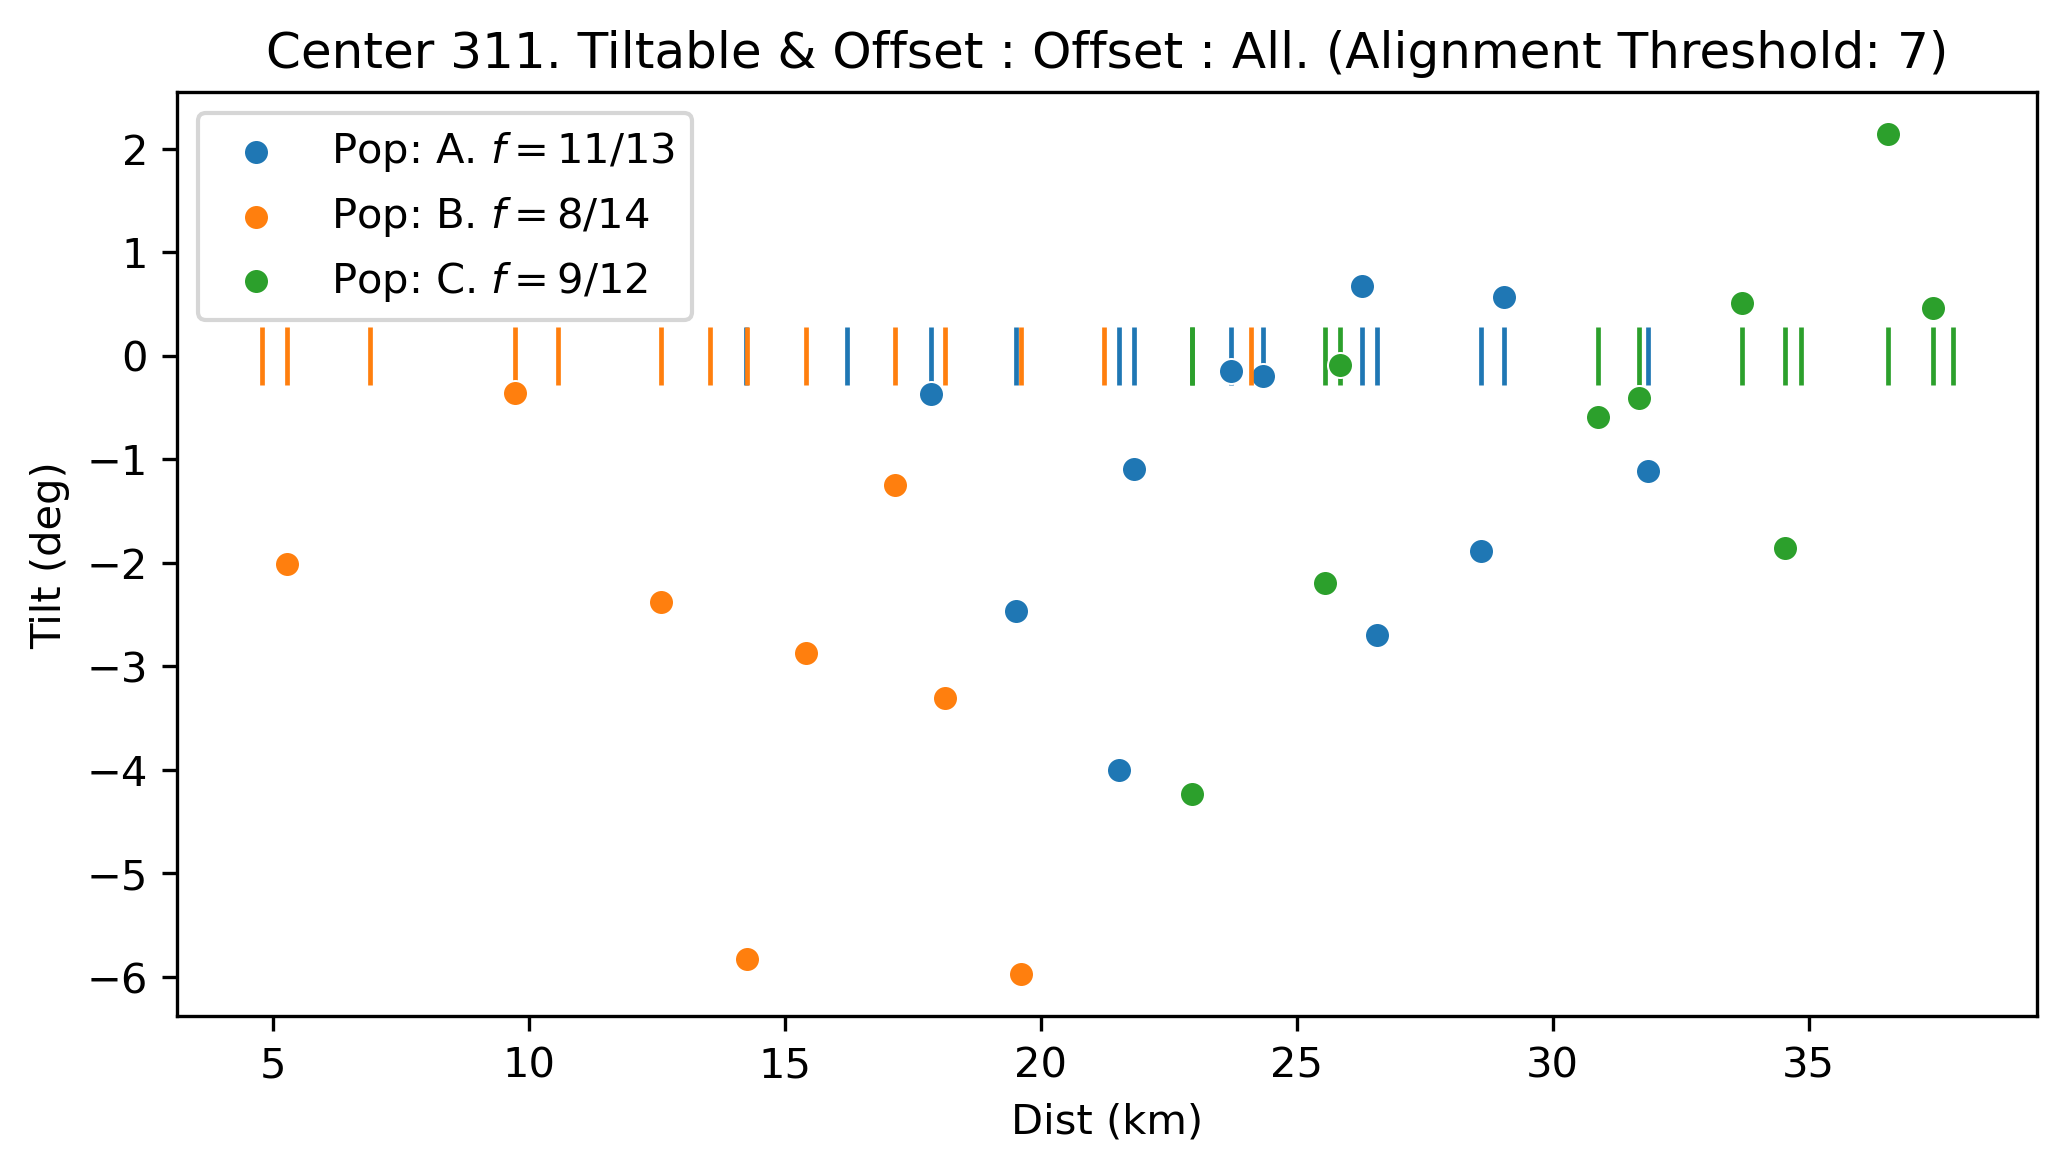

In [9]:
cID = 311

plt.figure(figsize=(8, 4), dpi=300)

alignment_threshold_degrees = 7
alignment_threshold = np.cos(np.radians(alignment_threshold_degrees))

centers_calc[cID].plot_tilt(
    [pop_a, pop_b, pop_c],
    max_alignment=alignment_threshold,
    min_alignment=-alignment_threshold,
)

plt.xlabel('Dist (km)')
plt.ylabel('Tilt (deg)')

# plt.ylim(-25,None)

plt.legend(loc='best')
plt.title(f'Center {cID}. Tiltable & Offset : Offset : All. (Alignment Threshold: {alignment_threshold_degrees})')


Define criteria for evaluation.

Define criteria and perform evaluation. This takes less than two minutes on my machine.

In [28]:
criteria = [
    td.Criterion(td.subset_sizes(7), pop_abc),
    td.Criterion(td.inflation_score(7), pop_abc),
    # td.Criterion(td.subset_sizes(1), pop_e),
    # td.Criterion(td.inflation_score, pop_e),
    # td.Criterion(td.subset_sizes(1), pop_w),
    # td.Criterion(td.inflation_score, pop_w),
]

scores = {}
score_names = []

# note: will get score name out of order if any criteria throw errors, so those need to be handled in each evaluation function
for cID, center in centers_calc.items():
    centers_eval = []

    for crit in criteria:
        center_crit_scores = td.evaluate_center(center, crit)

        for key, val in center_crit_scores.items():
            centers_eval.append(val)

            full_score_name = f'{crit.pop.name}_{key}'

            if full_score_name not in score_names:
                score_names.append(full_score_name)
                
    scores[cID] = centers_eval

centers_eval = pd.DataFrame(scores).transpose().set_axis(score_names, axis=1)
centers_eval_no_infs = centers_eval.replace([np.inf, -np.inf], np.nan)

Write evaluation to disk.

In [33]:
centers_eval_no_infs.to_csv(
    f'{map_path}centers_eval_abc.csv',
    index_label='cID'
)

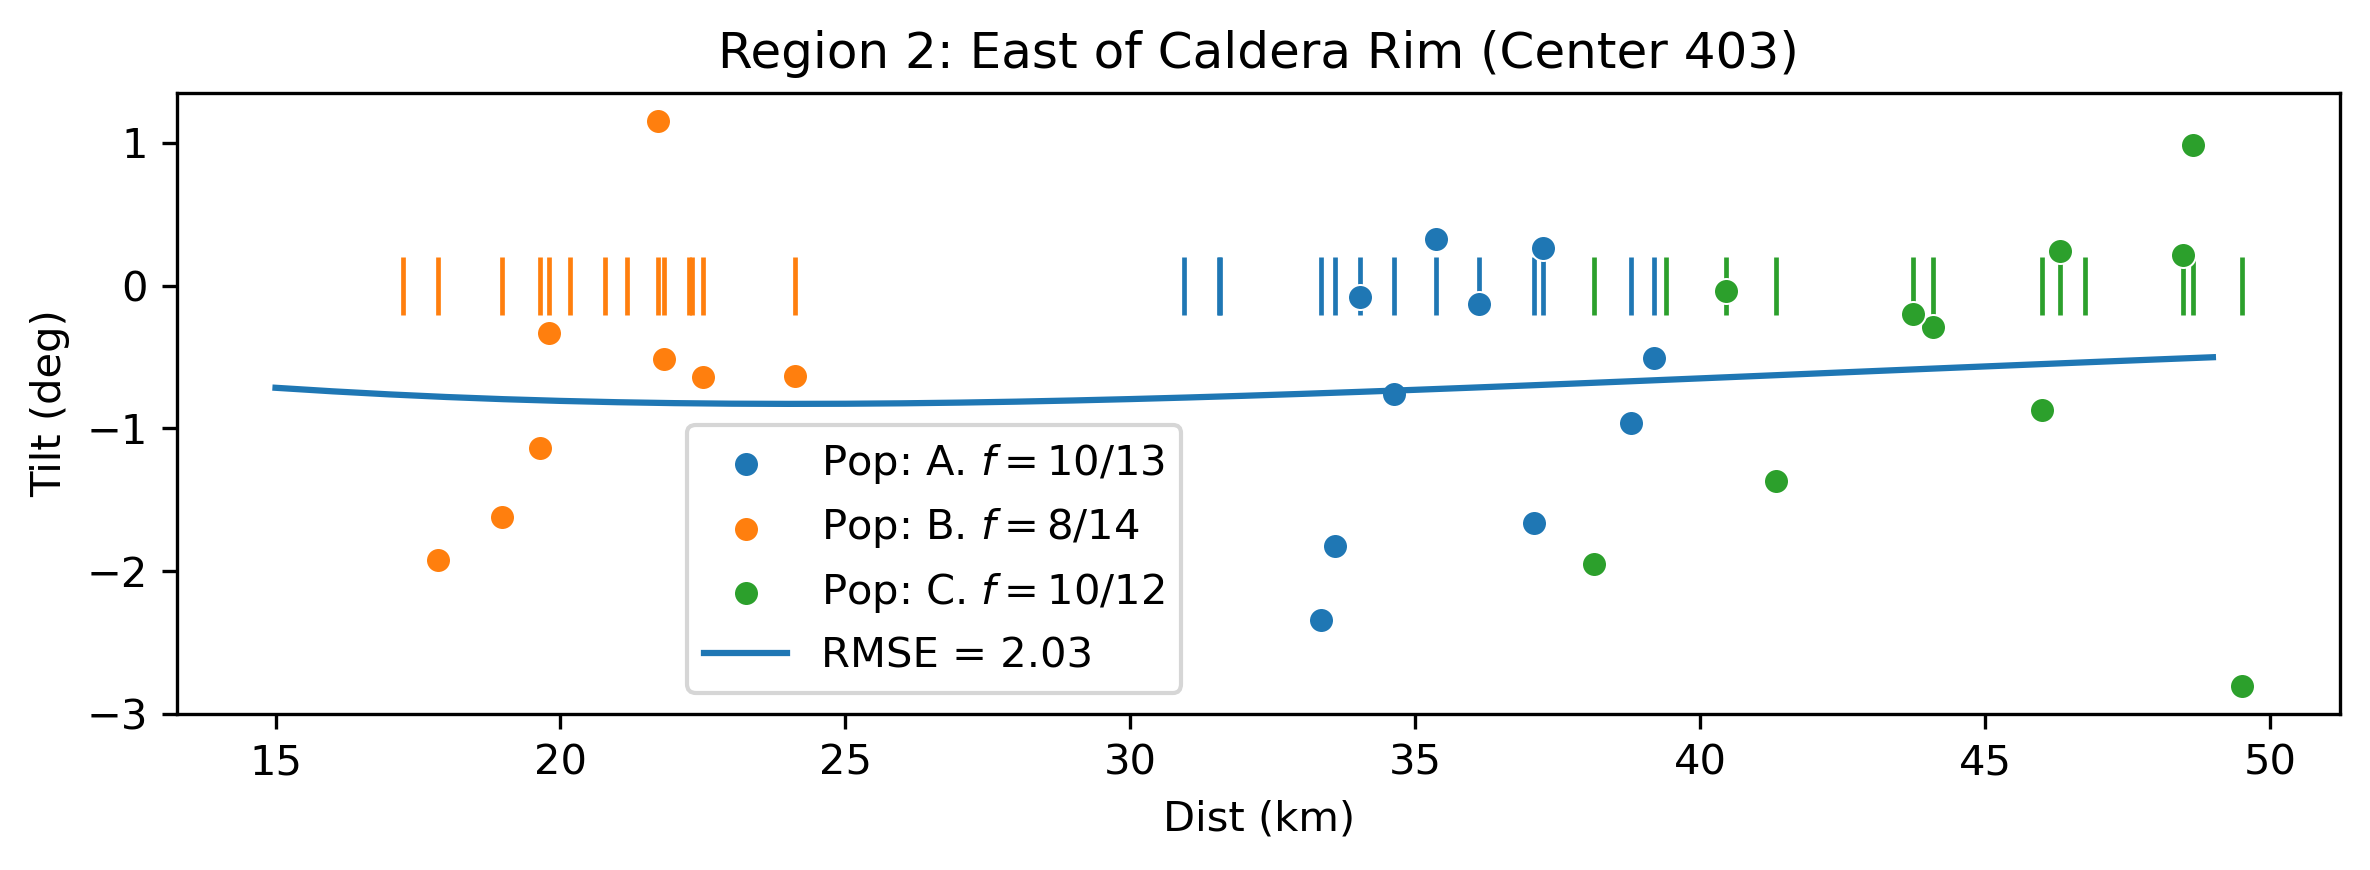

In [167]:
cID = 403

plt.figure(figsize=(8, 3), dpi=300)

alignment_threshold_degrees = 7
alignment_threshold = np.cos(np.radians(alignment_threshold_degrees))

centers_calc[cID].plot_tilt(
    [pop_a, pop_b, pop_c],
    max_alignment=alignment_threshold,
    min_alignment=-alignment_threshold,
)

plt.xlabel('Dist (km)')
plt.ylabel('Tilt (deg)')

# plt.ylim(-25,None)


eval = centers_eval_no_infs.loc[cID]

if eval['ABC_7_epv_is_positive']:
    mult = 1
else:
    mult = -1

fit_energy = 10**eval['ABC_7_log10_epv'] * mult
fit_d = eval['ABC_7_depth']

interval_m = np.arange(15000,50_000,1000)
fit_tilt = [td.mogi_tilt(dist,fit_energy, fit_d) for dist in interval_m]
interval_km = interval_m / 1000

sns.lineplot(x=interval_km,y=fit_tilt, label=f"RMSE = {round(eval['ABC_7_rmse'],2)}")

plt.title(f'Region 2: East of Caldera Rim (Center {cID})')
# plt.xlim(22.96, 22.97)
plt.legend(
    loc='center',
    bbox_to_anchor=(.35,.25)
    )
# plt.ylim(-20, None)

save_pdf(f'results/{cID}-analytical')

## Model data

Define parameter combinations.

In [61]:
grav_topo_test_params = {
    "depth": [15_000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [True, False],
    "topo": [True, False],
}

mogi_shallow_oblate_test_params = {
    "depth": [15_000, 20000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [False],
    "topo": [True],
}

mogi_test_params = {
    "depth": [25_000],
    "radius": [5_000],
    "aspect": [1],
    "pmult": [1],
    "grav": [False],
    "topo": [False],
}

In [26]:
coarse_params_shallow = {
    "depth": [4_000, 8_000, 12_000],
    "radius": [5_000, 10_000],
    "aspect": [0.2, 0.5, 0.7],
    "pmult": [-1, -0.5, 0.5, 1],
    "grav": [False],
    "topo": [True],
}

coarse_params_deep = {
    "depth": [16_000, 20_000, 24_000], # 25
    "radius": [20_000, 25_000, 30_000], # 5
    "aspect": [0.2, 0.3, 0.5],
    "pmult": [-1, 1, 2],
    "grav": [False],
    "topo": [True],
}

full_coarse_sweep = td.ParamSweep(
    td.unpack_param_combinations(coarse_params_shallow) 
    + td.unpack_param_combinations(coarse_params_deep)
)

In [6]:
len(full_coarse_sweep.models)

153

In [27]:
oblate_deflation_params = {
    "depth": [8000, 9000, 10_000, 11_000, 12_000], # 25
    "radius": [25_000, 26_000, 27_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.5, -0.75, -1, -1.25, -1.5],
    "grav": [False],
    "topo": [True],
}

oblate_deep_deflation_params = {
    "depth": [12_000, 14_000, 16_000], # 25
    "radius": [24_000, 26_000, 28_000, 30_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.75, -1, -1.25, -1.5, -1.75],
    "grav": [False],
    "topo": [True],
}

oblate_inflation_params = {
    "depth": [8000, 9000, 10_000, 11_000, 12_000], # 25
    "radius": [10_000, 26_000, 27_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.5, -0.75, -1, -1.25, -1.5],
    "grav": [False],
    "topo": [True],
}

oblate_deflation_sweep = td.ParamSweep(
    td.unpack_param_combinations(oblate_deflation_params)
    + td.unpack_param_combinations(oblate_deep_deflation_params)
)

model.params['depth']=8000
model.params['radius']=26000
model.params['aspect']=0.1
model.params['pmult']=-1.25


Text(0.5, 1.0, 'Center 310')

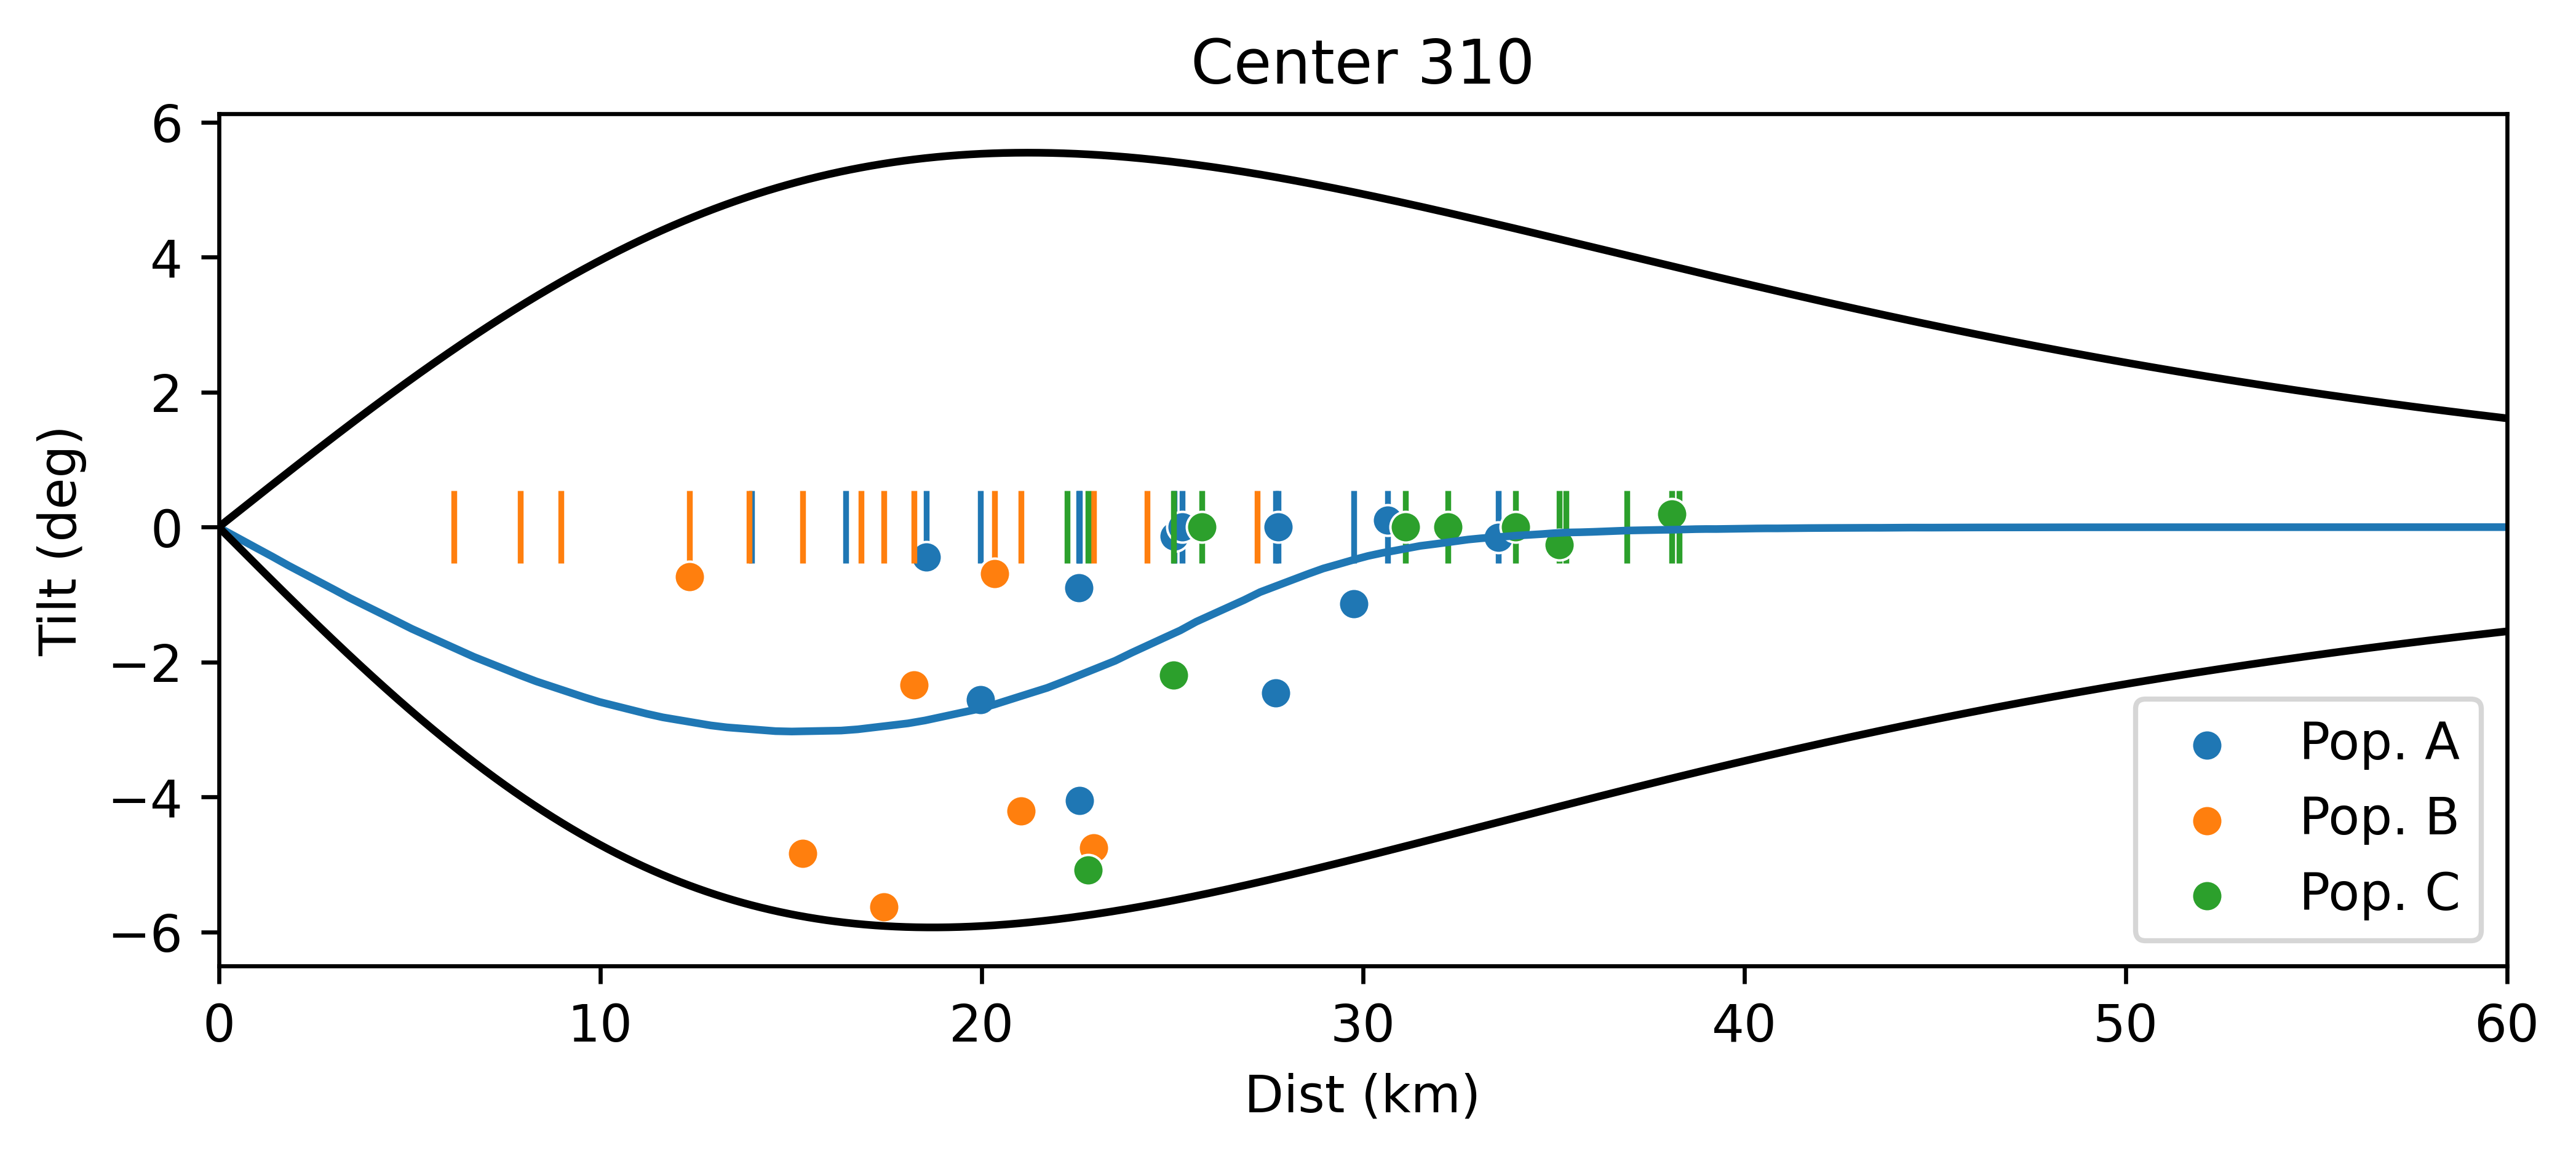

In [45]:
cID = 310

oblate_deflation_sweep.sort_models_by_rmse(
    center=centers_calc[cID],
    sIDs=pop_abc.sIDs
    )

plt.figure(figsize=(8,3), dpi=600)

for model in oblate_deflation_sweep.models[:1]:
    print(f"{model.params['depth']=}")
    print(f"{model.params['radius']=}")
    print(f"{model.params['aspect']=}")
    print(f"{model.params['pmult']=}")
    model.plot_numerical_tilt()

plt.ylabel('Tilt (deg)')
plt.xlabel('Dist (km)')
plt.xlim(0, 50)

# make a new higher cutoff function to use for excluding untiltables

td.MAX_EPV = 1e24
td.TEST_D = 40_000
td.plot_envelope(has_label=False)

centers_calc[cID].plot_tilt(
    [pop_a, pop_b, pop_c]
)

plt.legend(loc='lower right')
plt.xlim(0,60)

plt.title(f'Center {cID}')

In [16]:
len(oblate_deflation_sweep.models)

540

In [1]:
possible_collapse_center_cIDs = [310, 311]

for cID in possible_collapse_center_cIDs:
    oblate_deflation_sweep.sort_models_by_rmse(
    center=centers_calc[cID],
    sIDs=pop_abc.sIDs
    )

    model = oblate_deflation_sweep.models[0]

    print(f"{cID}: {model.params =}")

    

NameError: name 'oblate_deflation_sweep' is not defined

In [47]:
df = pd.DataFrame({
    'a':[1,2],
    'b':[3,np.nan]
})

In [52]:
len(df[df['b'].notnull()])

1

In [23]:
dir(type)

['__abstractmethods__',
 '__annotations__',
 '__base__',
 '__bases__',
 '__basicsize__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dictoffset__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__flags__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__instancecheck__',
 '__itemsize__',
 '__le__',
 '__lt__',
 '__module__',
 '__mro__',
 '__name__',
 '__ne__',
 '__new__',
 '__or__',
 '__prepare__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__ror__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasscheck__',
 '__subclasses__',
 '__subclasshook__',
 '__text_signature__',
 '__weakrefoffset__',
 'mro']